In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
def Inductor(deg,N):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,0.025)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.275)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.775)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.025)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.025)),
        geometry.unit_square().scale(0.5).translate((1.5,1.025)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [4]:
mu0 = 4*pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}

In [5]:
deg=2
M = Inductor(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
maxiter=7
uh=[]
numdofs = np.zeros(maxiter,dtype=float)
P=[]
return_P = True

for i in range(maxiter):
    print('----------------------------------------------------')
    print(i)
    bcs = MP.compute_dirichlet_bcs({0:0.})
    Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    Mh = MP.assemble_volume(vform.mass_vf(2))
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    numdofs[i] = MP.numdofs
    print('Number of doFs: ' + str(MP.numdofs))
    print('Energy: ' + str(MP.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_ =uh[-1], nu=nu)*0.0254))
    
    if i < maxiter-2:
        P.append(MP.h_refine(h_ref=-1, return_P=return_P))
    elif i == maxiter-2:
        P.append(MP.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err = np.zeros(maxiter)
H1err = np.zeros(maxiter)
Aherr = np.zeros(maxiter)
for i in range(len(uh)-1):
    eh = P[i]@uh[i]-uh[-1]
    L2err[i] = eh @ Mh @ eh
    H1err[i] = eh @ Kh @ eh + L2err[-1]
    Aherr[i] = eh @ Ah @ eh
    
L2err = sqrt(L2err)
H1err = sqrt(H1err)
Aherr = sqrt(Aherr)

#np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs,H1err,L2err,Aherr]])

Basis setup took 0.01882648468017578 seconds
----------------------------------------------------
0
Number of doFs: 725
Energy: 0.0008136772762026942
Refinement took 0.001527547836303711 seconds
Basis setup took 0.028345346450805664 seconds
Prolongation took 0.0734860897064209 seconds
----------------------------------------------------
1
Number of doFs: 2150
Energy: 0.0008438974473196564
Refinement took 0.0012481212615966797 seconds
Basis setup took 0.062465667724609375 seconds
Prolongation took 0.0788571834564209 seconds
----------------------------------------------------
2
Number of doFs: 7268
Energy: 0.0008644775915588775
Refinement took 0.0011832714080810547 seconds
Basis setup took 0.19837117195129395 seconds
Prolongation took 0.0886843204498291 seconds
----------------------------------------------------
3
Number of doFs: 26576
Energy: 0.0008758726845036421
Refinement took 0.0013086795806884766 seconds
Basis setup took 0.6332864761352539 seconds
Prolongation took 0.109142541885

Basis setup took 0.018030405044555664 seconds
------------------------------------------------------
0
Number of DoFs: 725
Energy: 0.0008136772762026942
Residual contributions took 0.2807121276855469 seconds.
Jump contributions took 0.43597960472106934 seconds.
Refinement took 0.05054903030395508 seconds
Basis setup took 0.034918785095214844 seconds
Prolongation took 0.06119418144226074 seconds


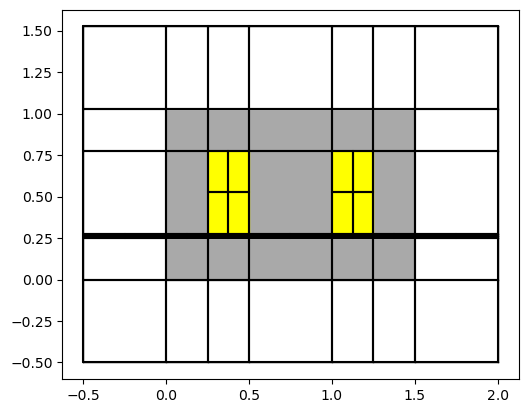

------------------------------------------------------
1
Number of DoFs: 1125
Energy: 0.0008384212218092091
Residual contributions took 0.4483344554901123 seconds.
Jump contributions took 1.0096893310546875 seconds.
Refinement took 0.15608763694763184 seconds
Basis setup took 0.06334137916564941 seconds
Prolongation took 0.1291334629058838 seconds


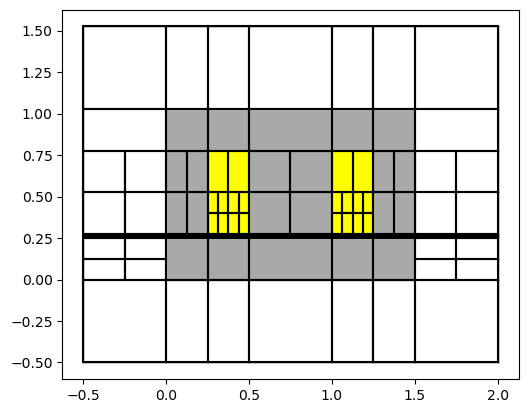

------------------------------------------------------
2
Number of DoFs: 1985
Energy: 0.0008566603713084647
Residual contributions took 0.7920703887939453 seconds.
Jump contributions took 1.871953010559082 seconds.
Refinement took 0.3553450107574463 seconds
Basis setup took 0.11315274238586426 seconds
Prolongation took 0.18891692161560059 seconds


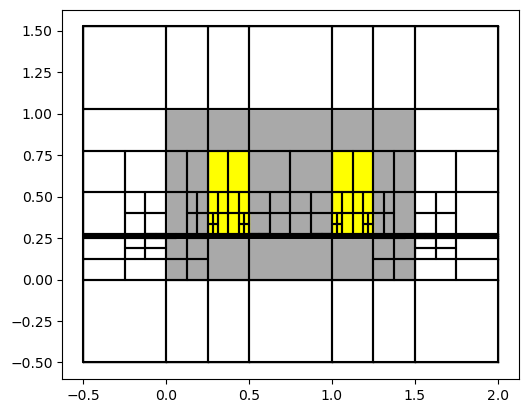

------------------------------------------------------
3
Number of DoFs: 3221
Energy: 0.0008687722056413158
Residual contributions took 1.271186351776123 seconds.
Jump contributions took 3.251652717590332 seconds.
Refinement took 0.5351135730743408 seconds
Basis setup took 0.15457820892333984 seconds
Prolongation took 0.21283221244812012 seconds


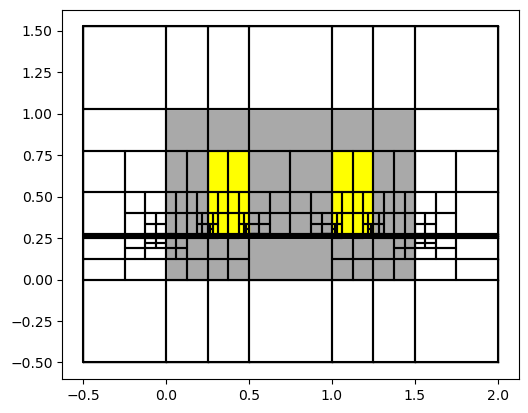

------------------------------------------------------
4
Number of DoFs: 4633
Energy: 0.0008754843568348886
Residual contributions took 1.8827404975891113 seconds.
Jump contributions took 4.775602102279663 seconds.
Refinement took 0.8659007549285889 seconds
Basis setup took 0.20851969718933105 seconds
Prolongation took 0.2571899890899658 seconds


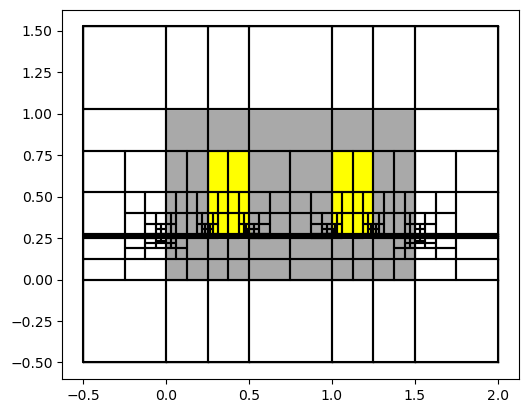

------------------------------------------------------
5
Number of DoFs: 6261
Energy: 0.0008789471047938764
Residual contributions took 2.579097032546997 seconds.
Jump contributions took 6.70624566078186 seconds.
Refinement took 1.4529170989990234 seconds
Basis setup took 0.3016166687011719 seconds
Prolongation took 0.33245372772216797 seconds


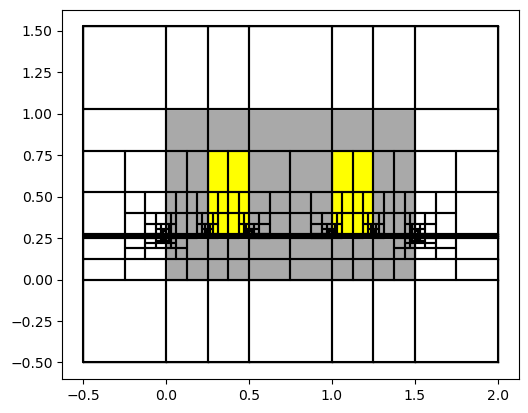

------------------------------------------------------
6
Number of DoFs: 8377
Energy: 0.0008807904496370311
Residual contributions took 3.44807505607605 seconds.
Jump contributions took 8.955775499343872 seconds.
Refinement took 2.64067006111145 seconds
Basis setup took 0.47692251205444336 seconds
Prolongation took 0.4597294330596924 seconds


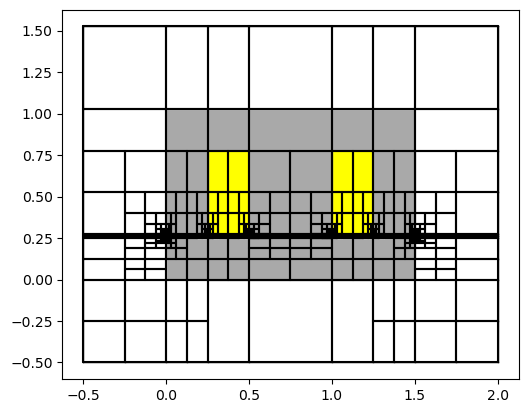

------------------------------------------------------
7
Number of DoFs: 11217
Energy: 0.0008818127041213609
Residual contributions took 4.63295841217041 seconds.
Jump contributions took 12.14870572090149 seconds.
Refinement took 4.586223602294922 seconds
Basis setup took 0.6294386386871338 seconds
Prolongation took 0.6186504364013672 seconds


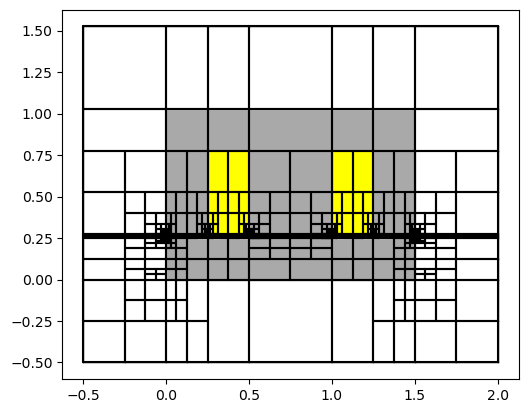

------------------------------------------------------
8
Number of DoFs: 15029
Energy: 0.0008824694503281166
Basis setup took 1.1430187225341797 seconds
Prolongation took 1.831817626953125 seconds
------------------------------------------------------
9
Number of DoFs: 47342
Energy: 0.0008834303627531146


In [6]:
deg=2
M_a=Inductor(deg,deg+1)
MP_a = assemble.Multipatch(M_a, automatch=True)
uh_a=[]
P_a=[]
err_ind=[]

maxiter=10
numdofs_a =np.zeros(maxiter)
err_est=np.zeros(maxiter)

for i in range(maxiter):
    print('------------------------------------------------------')
    print(i)
    bcs = MP_a.compute_dirichlet_bcs({0:0.})
    Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP_a.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
    Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
    Mh_a = MP_a.assemble_volume(vform.mass_vf(2))

    LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
    uh_a.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    print('Number of DoFs: ' + str(MP_a.numdofs))
    print('Energy: ' + str(MP_a.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_=uh_a[-1], nu=nu)*0.0254))
    numdofs_a[i]=MP_a.numdofs
    
    if i < maxiter-2 :
        err_ind.append(adap.PoissonEstimator(MP_a, uh_a[-1], f=j, a=nu, M=MaT))
        err_est[i] = norm(err_ind[-1])
        marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
        MP_a.mesh.draw(color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'})
        plt.show()
    elif i == maxiter-2:
        P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
    else:
        pass
    
for k in reversed(range(1,len(P_a))):
    P_a[k-1]=P_a[k]@P_a[k-1]
    
L2err_a = np.zeros(maxiter)
H1err_a = np.zeros(maxiter)
Aherr_a = np.zeros(maxiter)
for i in range(len(uh_a)-1):
    eh = P_a[i]@uh_a[i]-uh_a[-1]
    L2err_a[i] = eh @ Mh_a @ eh
    H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
    Aherr_a[i] = eh @ Ah_a @ eh
    
L2err_a = sqrt(L2err_a)
H1err_a = sqrt(H1err_a)
Aherr_a = sqrt(Aherr_a)

#np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,Aherr_a]])

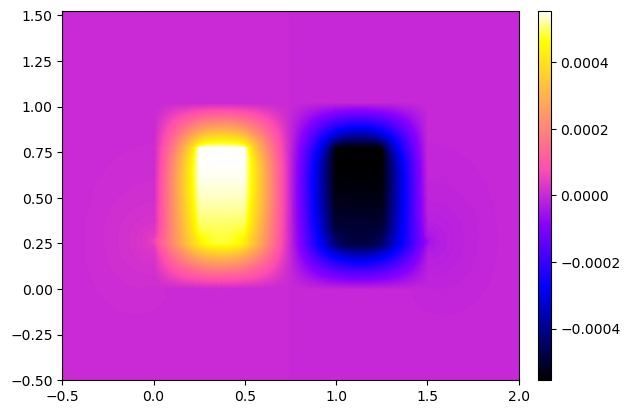

In [9]:
MP_a.plot(uh_a[-1], cmap='gnuplot2')

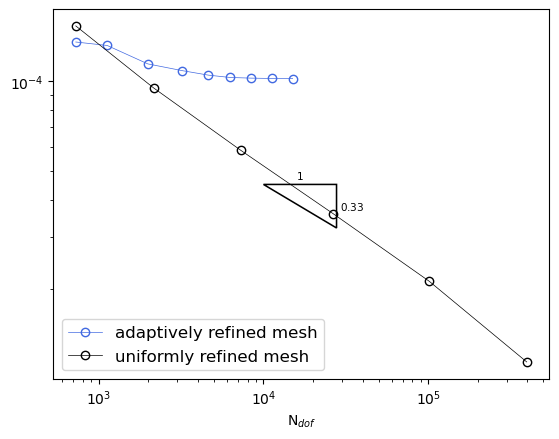

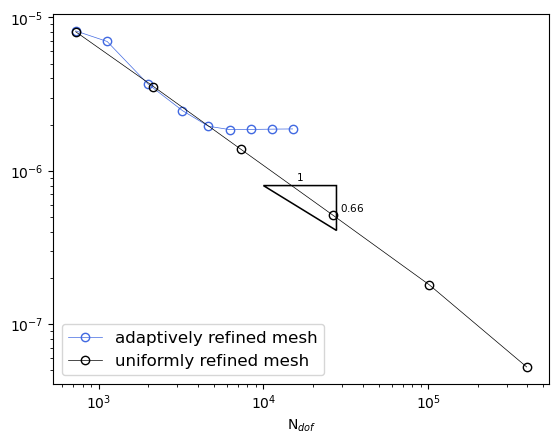

In [31]:
deg=2
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
#draw_loglog_slope(fig,ax,(8*1e4,0.4*1e-7),2,1.5 ,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.45*1e-4),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
#draw_loglog_slope(fig,ax,(8*1e4,1.8*1e-7),2,4 if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,8*1e-7),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
plt.show()

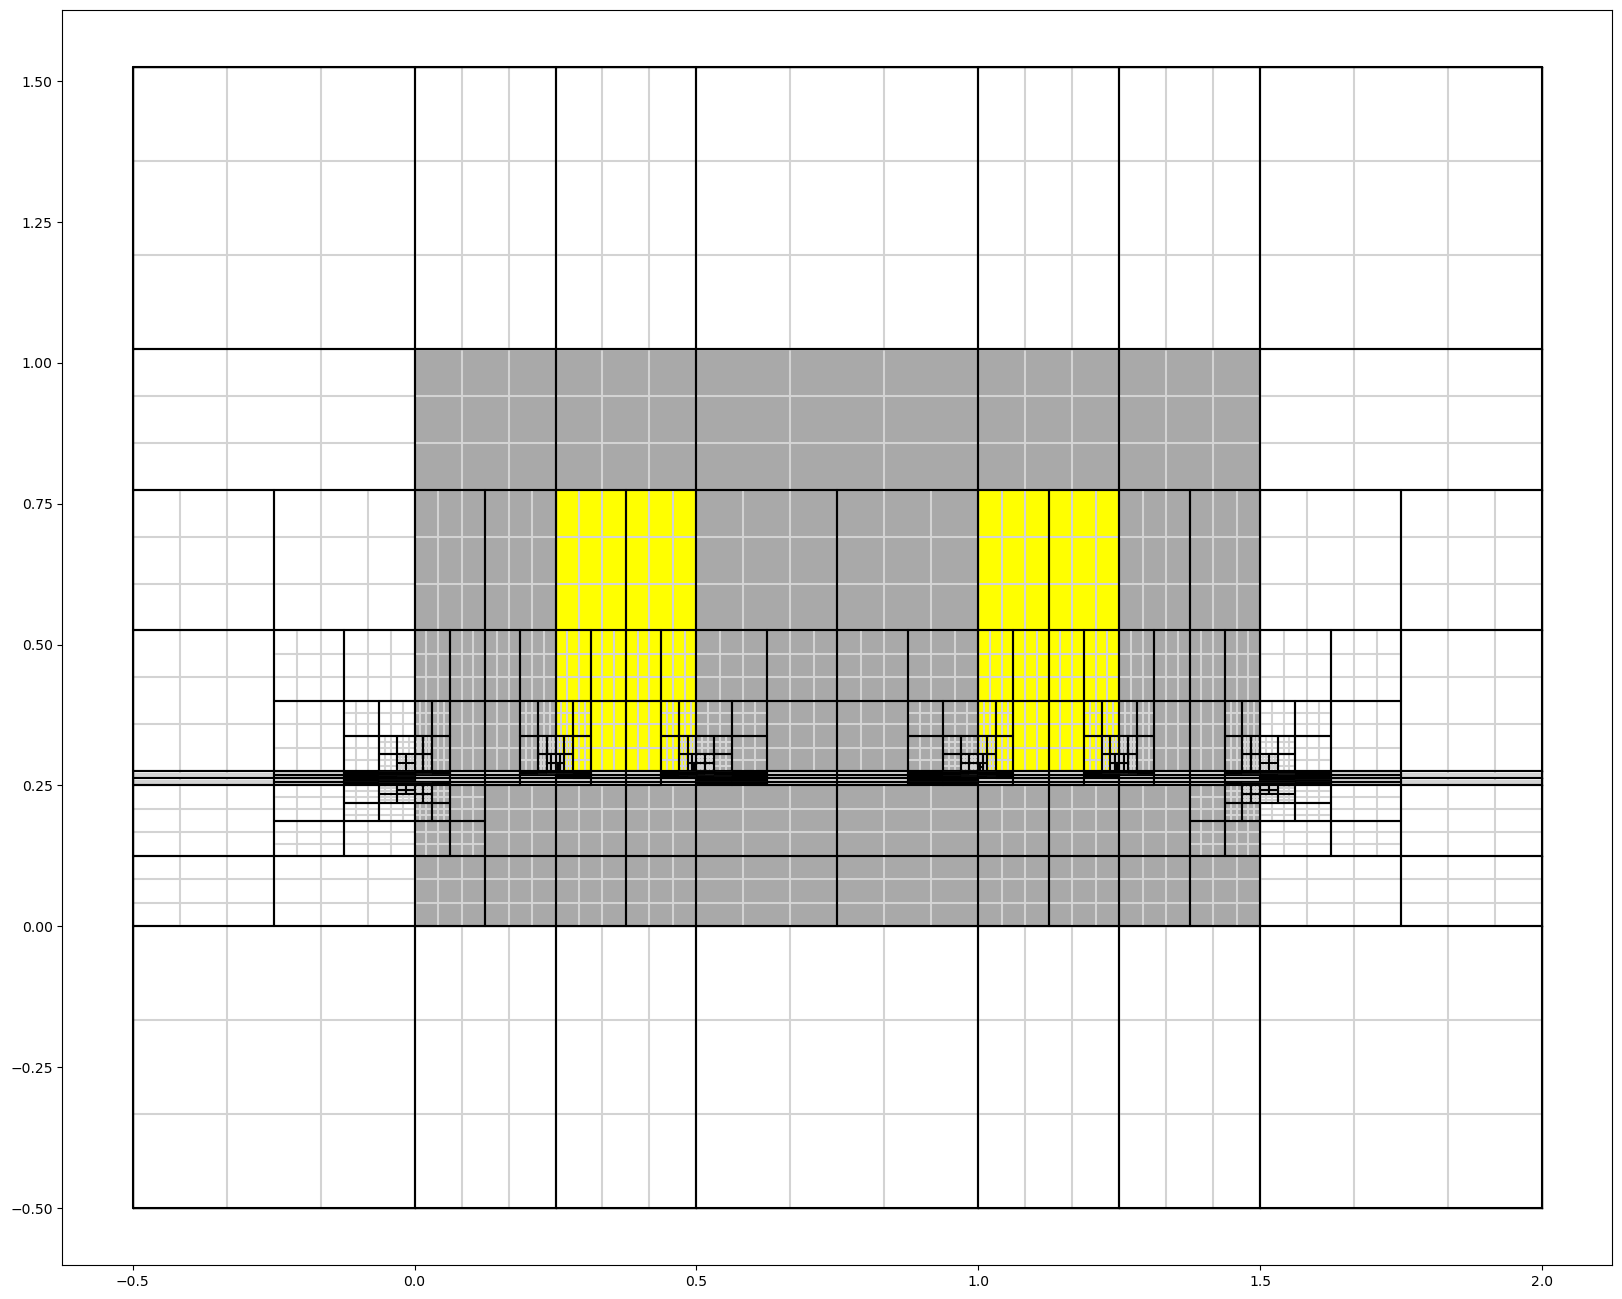

In [34]:
MP_a.mesh.draw(knots=True, color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'}, figsize=(20,20))

In [ ]:
M.draw(knots=True, patch_idx=False, figsize=(10,10), color={'Air':'white', 'Fe':'darkgray', 'C1':'yellow', 'C2':'yellow'})

In [12]:
MP_a.integrate

{'Air': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}}